# Train an AI to solve the Frozen Lake environment

[Q-learning for beginners](https://mlabonne.github.io/blog/reinforcement%20learning/q-learning/frozen%20lake/gym/tutorial/2022/02/13/Q_learning.html)

In [1]:
import random

import gym
import numpy as np

gym.__version__

'0.26.2'

## Make it faster by not showing it at first

In [2]:
environment = gym.make("FrozenLake-v1", is_slippery=False)

environment.reset()
environment.render()

/usr/local/anaconda3/lib/python3.9/site-packages/gym/envs/toy_text/frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(


In [3]:
vars(environment)

{'env': <OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>,
 '_action_space': None,
 '_observation_space': None,
 '_reward_range': None,
 '_metadata': None,
 '_max_episode_steps': 100,
 '_elapsed_steps': 0}

In [4]:
dir(environment)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_action_space',
 '_elapsed_steps',
 '_is_protocol',
 '_max_episode_steps',
 '_metadata',
 '_np_random',
 '_observation_space',
 '_reward_range',
 'action_space',
 'class_name',
 'close',
 'env',
 'metadata',
 'np_random',
 'observation_space',
 'render',
 'render_mode',
 'reset',
 'reward_range',
 'spec',
 'step',
 'unwrapped']

In [5]:
environment.class_name()

'TimeLimit'

In [6]:
environment.metadata

{'render_modes': ['human', 'ansi', 'rgb_array'], 'render_fps': 4}

In [7]:
environment.reward_range

(0, 1)

In [8]:
environment.spec

EnvSpec(id='FrozenLake-v1', entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'map_name': '4x4', 'is_slippery': False}, namespace=None, name='FrozenLake', version=1)

In [9]:
environment.spec.kwargs

{'map_name': '4x4', 'is_slippery': False}

In [10]:
environment.unwrapped

## Learning which action you should choose in every state

16 tiles = positions = **states**

For each state, there are 4 possible **actions**; go:

◀️ LEFT = 0

🔽 DOWN = 1

▶️ RIGHT = 2

🔼 UP = 3

Learning how to play Frozen Lake is like _learning which action you should choose in every state._

In [11]:
# Let's create our Q-table and fill it with zeros since we still have no idea 
# of the value of each action in each state.

nb_states = environment.observation_space.n
nb_actions = environment.action_space.n

qtable = np.zeros((nb_states, nb_actions))

# Let's see how it looks
print('\nQ-table =')
print(qtable)


Q-table =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [12]:
# Let's say that the agent takes a random action
random.choice(["LEFT", "DOWN", "RIGHT", "UP"])

'RIGHT'

In [13]:
# Randomly choose an action
environment.action_space.sample()

3

No worries, we can [check the source code on GitHub](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py#L10) to understand what these numbers mean.

## Solve it manually

In [18]:
# import time
# import gym

# environment1 = gym.make("FrozenLake-v1", is_slippery=False, render_mode="human")
# environment1.reset()
# environment1.render()

# for x in range(2):
#     # Implement this action and move our agent in the desired direction
#     environment1.step(2)
#     # Display the current map to see what we're doing
#     environment1.render()

# for x in range(3):
#     environment1.step(1)
#     environment1.render()

# new_state, reward, done, c, info = environment1.step(2)
# environment1.render()

# print(f'Reward = {reward}')

# print(new_state, reward, done, c, info)

# Reward = 1.0
# 15 1.0 True False {'prob': 1.0}

# environment1.reset()
# (0, {'prob': 1})

# Wait for 15 seconds
# time.sleep(15)

# Close the window
# environment1.close()

## What are these values?

In [19]:
state = environment.reset()

type(state), state[0]

(tuple, 0)

In [20]:
state = environment.reset()[0]
state

0

In [21]:
type(qtable[state]), qtable[state], qtable[0][0]

(numpy.ndarray, array([0., 0., 0., 0.]), 0.0)

## Set up plot

In [22]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 17})

## Train our agent (1)

In [23]:
# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor

# List of outcomes to plot
outcomes = []

print('Q-table before training:')
print(qtable)

# Training
for _ in range(episodes):
    state = environment.reset()[0]
    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
            action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success

        if reward:
            outcomes[-1] = "Success"

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-table after training:
[[0.      0.59049 0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.6561  0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.729   0.     ]
 [0.      0.      0.81    0.     ]
 [0.      0.9     0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      1.      0.     ]
 [0.      0.      0.      0.     ]]


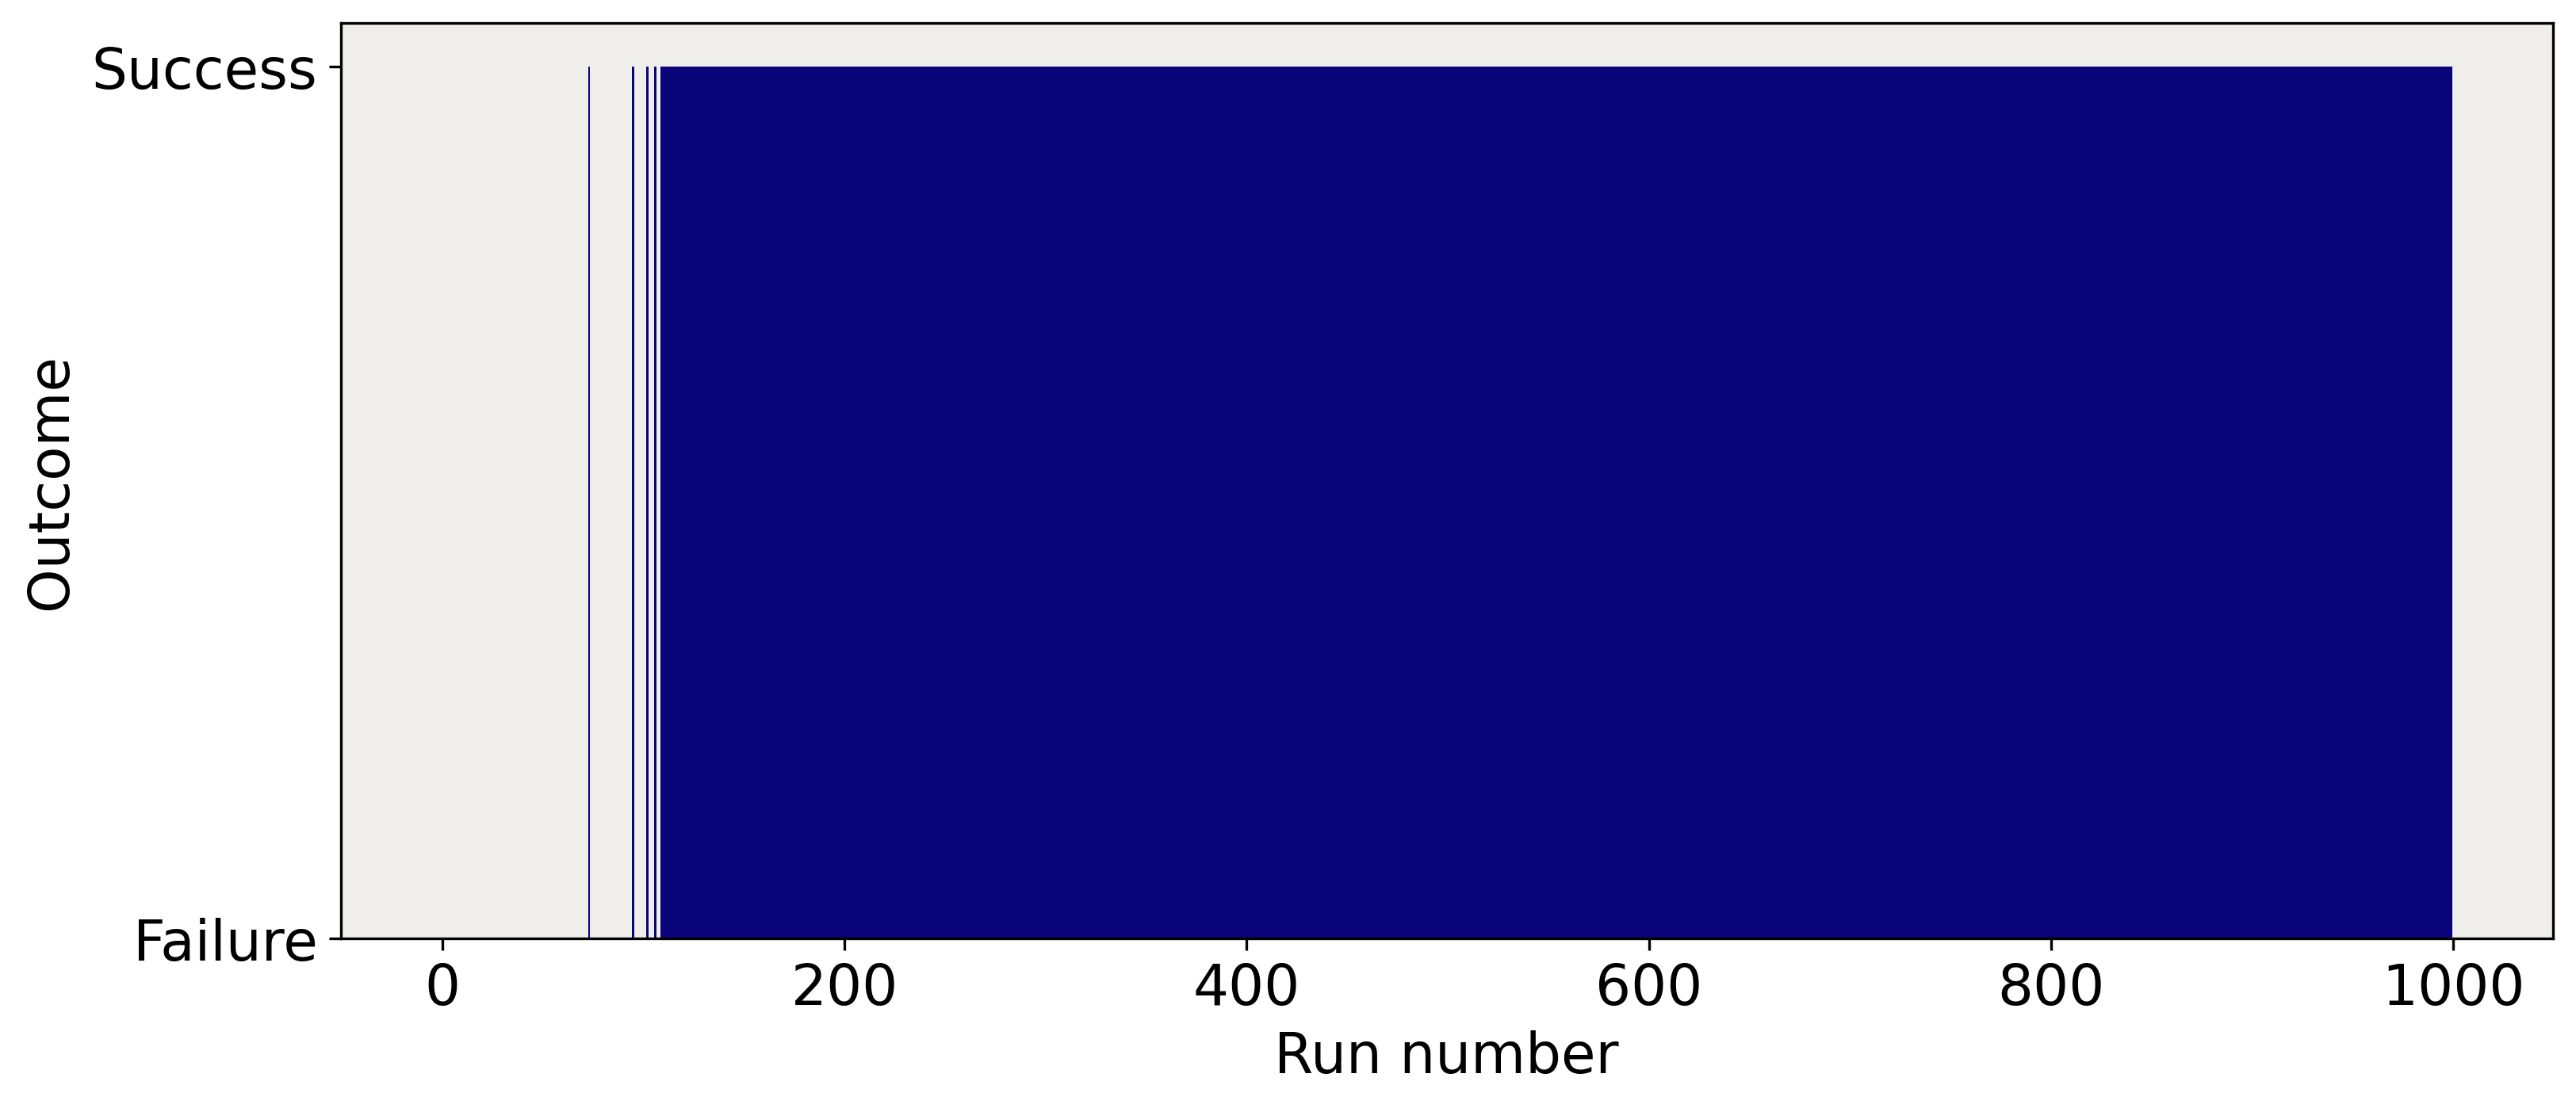

In [24]:
# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()

## Evaluate it on 100 episodes

In [25]:
episodes = 100
nb_success = 0

# Evaluation
for _ in range(episodes):
    state = environment.reset()[0]
    done = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
            action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print(f"\nFormula = {nb_success} / {episodes} * 100%")
print(f"\nSuccess rate = {nb_success / episodes * 100}%")



Formula = 100.0 / 100 * 100%

Success rate = 100.0%


## Visualize the agent moving on the map

In [26]:
# IT WORKED BEFORE

# import time

# import gym
# import random
# import numpy as np
# from IPython.display import clear_output

# qtable = [[0.0, 0.0, 0.59049, 0.0],
#           [0.0, 0.0, 0.6561, 0.0],
#           [0.0, 0.729, 0.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0],
#           [0.0, 0.81, 0.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0],
#           [0.0, 0.0, 0.0455625, 0.0],
#           [0.0, 0.0, 0.3290625, 0.0],
#           [0.0, 0.9, 0.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0],
#           [0.0, 0.0, 1.0, 0.0],
#           [0.0, 0.0, 0.0, 0.0]]

# environment1 = gym.make("FrozenLake-v1", is_slippery=False, render_mode="human")
# state = environment1.reset()[0]
# done = False
# sequence = []

# while not done:
#     # Choose the action with the highest value in the current state
#     if np.max(qtable[state]) > 0:
#         action = np.argmax(qtable[state])

#     # If there's no best action (only zeros), take a random one
#     else:
#         action = environment1.action_space.sample()

#     # Add the action to the sequence
#     sequence.append(action)

#     # Implement this action and move the agent in the desired direction
#     new_state, reward, done, _, info = environment1.step(action)

#     # Update our current state
#     state = new_state

#     # Update the render
#     clear_output(wait=True)
#     environment1.render()
#     time.sleep(1)  # Close the window
#     environment1.close()

# print(f"\nAction sequence = {sequence}")


## Implement Epsilon-Greedy algorithm and see how it changes the agent's behavior

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Q-table after training:
[[0.531441   0.59049    0.59049    0.531441  ]
 [0.531441   0.         0.6561     0.59049   ]
 [0.59049    0.729      0.59049    0.6561    ]
 [0.6561     0.         0.59046944 0.59048486]
 [0.590417   0.6561     0.         0.53144055]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.6561    ]
 [0.         0.         0.         0.        ]
 [0.65538534 0.         0.729      0.58977171]
 [0.65248172 0.80998474 0.81       0.        ]
 [0.729      0.9        0.         0.729     ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.80929828 0.9        0.70601636]
 [0.81       0.9        1.         0.81      ]
 [0

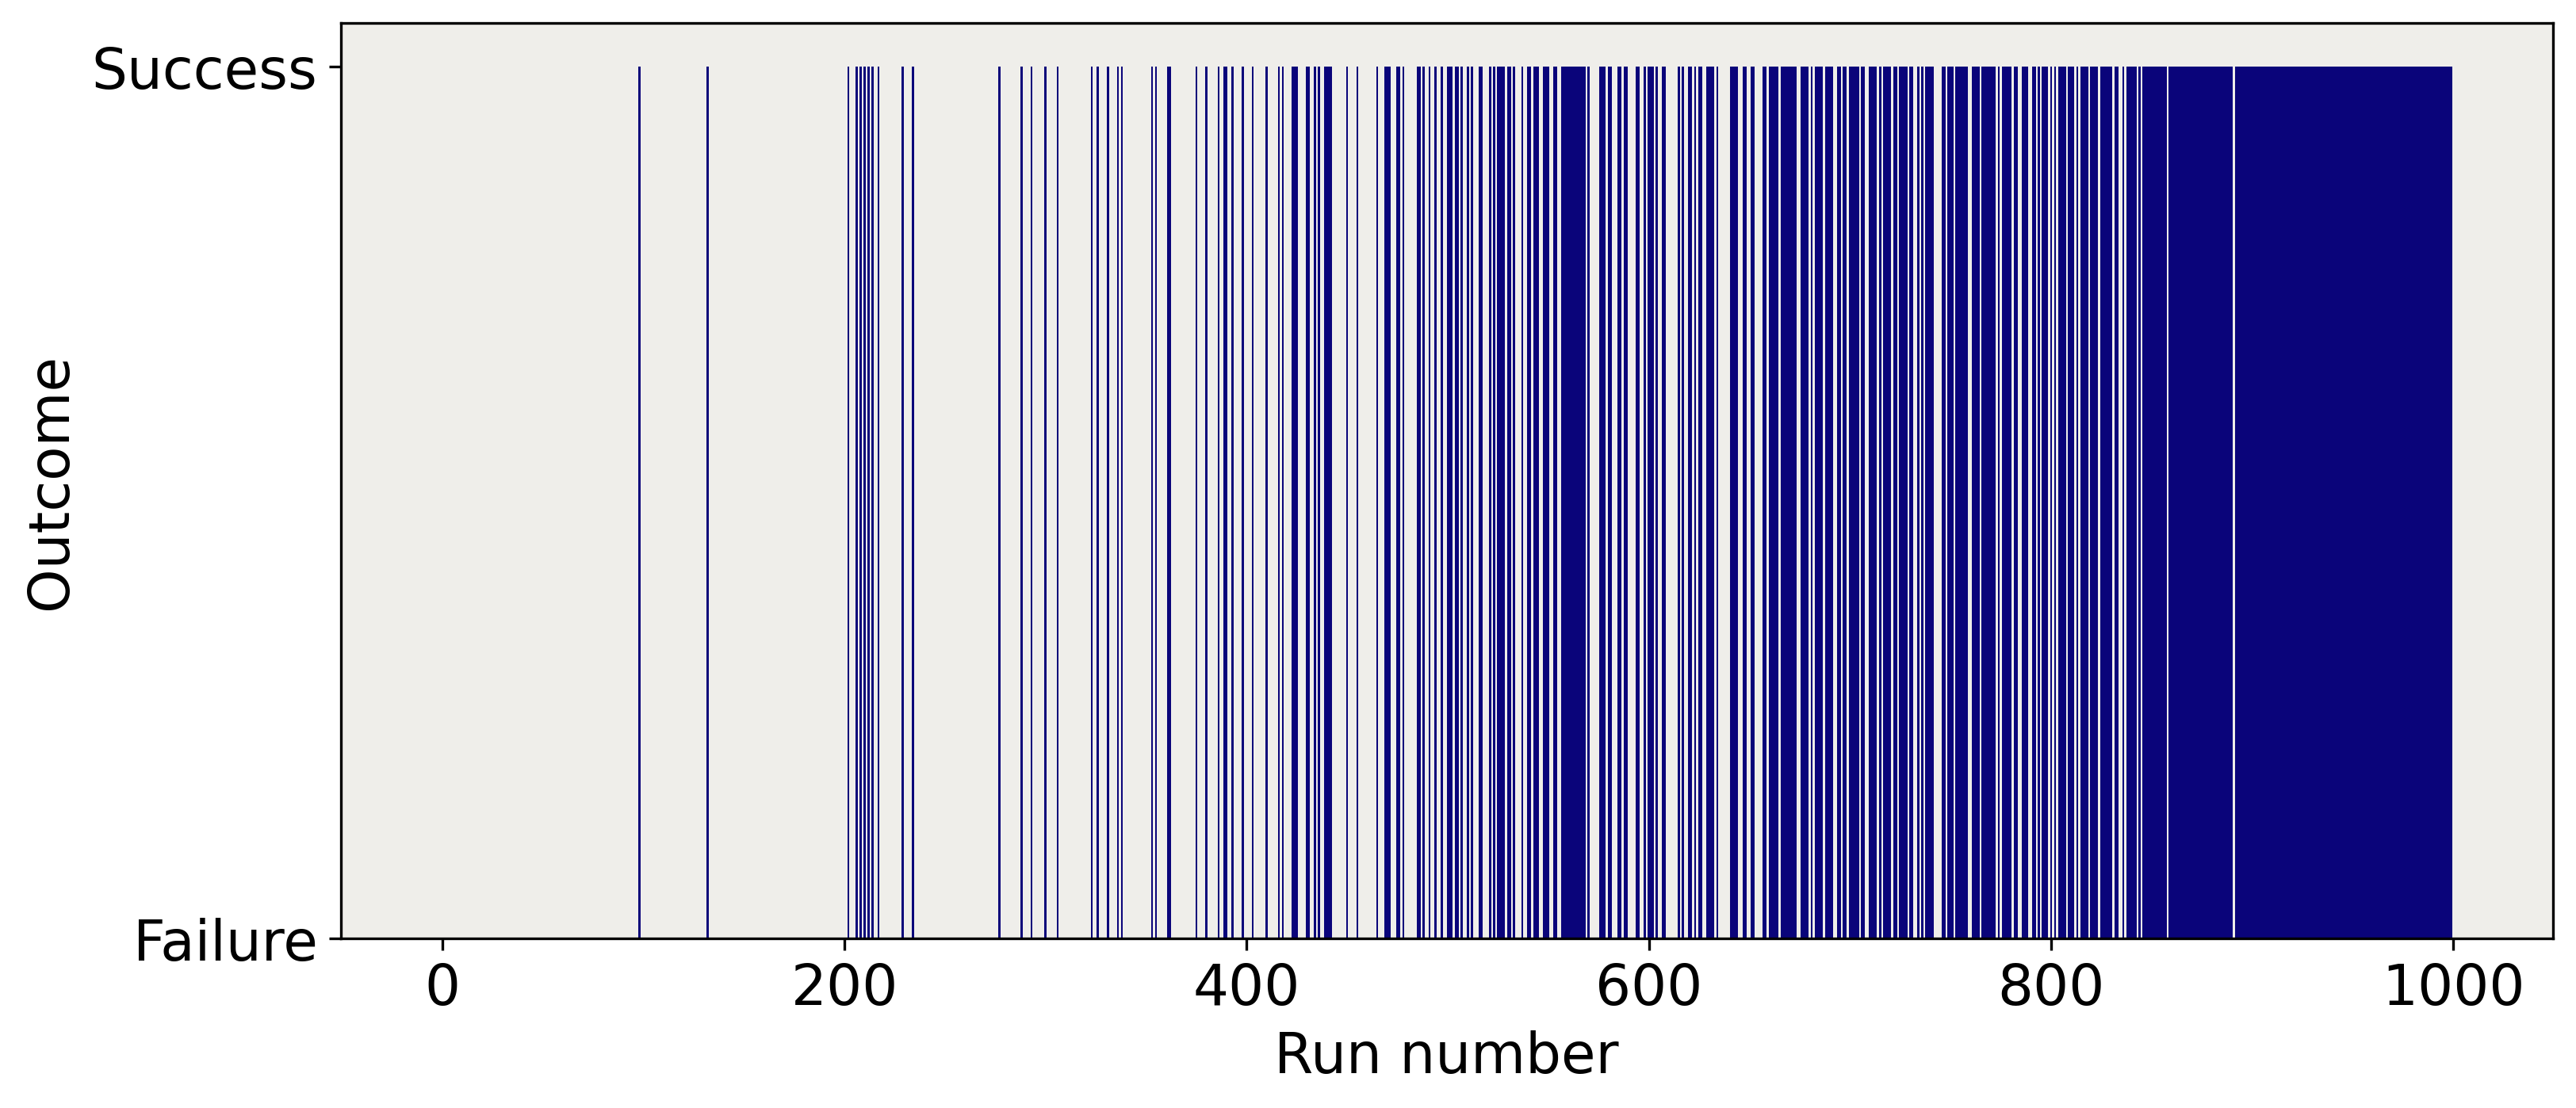

In [27]:
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor

# NEW!
epsilon = 1.0  # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

# List of outcomes to plot
outcomes = []

print('Q-table before training:')
print(qtable)

# Training
for _ in range(episodes):
    state = environment.reset()[0]
    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # Generate a RANDOM NUMBER between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:
            action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:
            action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)
    # print("\nepsilon", epsilon)  # Starts at one and goes to zero

print()
print('===========================================')
print('\nQ-table after training:')
print(qtable)

# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()


## Evalutate

In [28]:
# We leave out a few things in this one
episodes = 100
nb_success = 0

# Evaluation
for _ in range(episodes):
    state = environment.reset()[0]
    done = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print(f"\nSuccess rate = {nb_success / episodes * 100}%")



Success rate = 100.0%


# Slippery Frozen Lake

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-table after training:
[[0.05133943 0.03038311 0.03040517 0.03025119]
 [0.017395   0.02024574 0.00855843 0.02770777]
 [0.01777512 0.02323507 0.02030561 0.02368286]
 [0.01661542 0.00819438 0.01819607 0.0205518 ]
 [0.09481467 0.0350259  0.03666838 0.01016722]
 [0.         0.         0.         0.        ]
 [0.0036258  0.00340805 0.00516096 0.00512899]
 [0.         0.         0.         0.        ]
 [0.05199729 0.03504772 0.02915928 0.11745956]
 [0.06526277 0.08668545 0.13034009 0.00906945]
 [0.02756214 0.3464397  0.01477571 0.02741575]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.2852304  0.18466241 0.45347261 0.17593535]
 [0.30502762 0.45150466 0.43800041 0.28041808]
 [0.

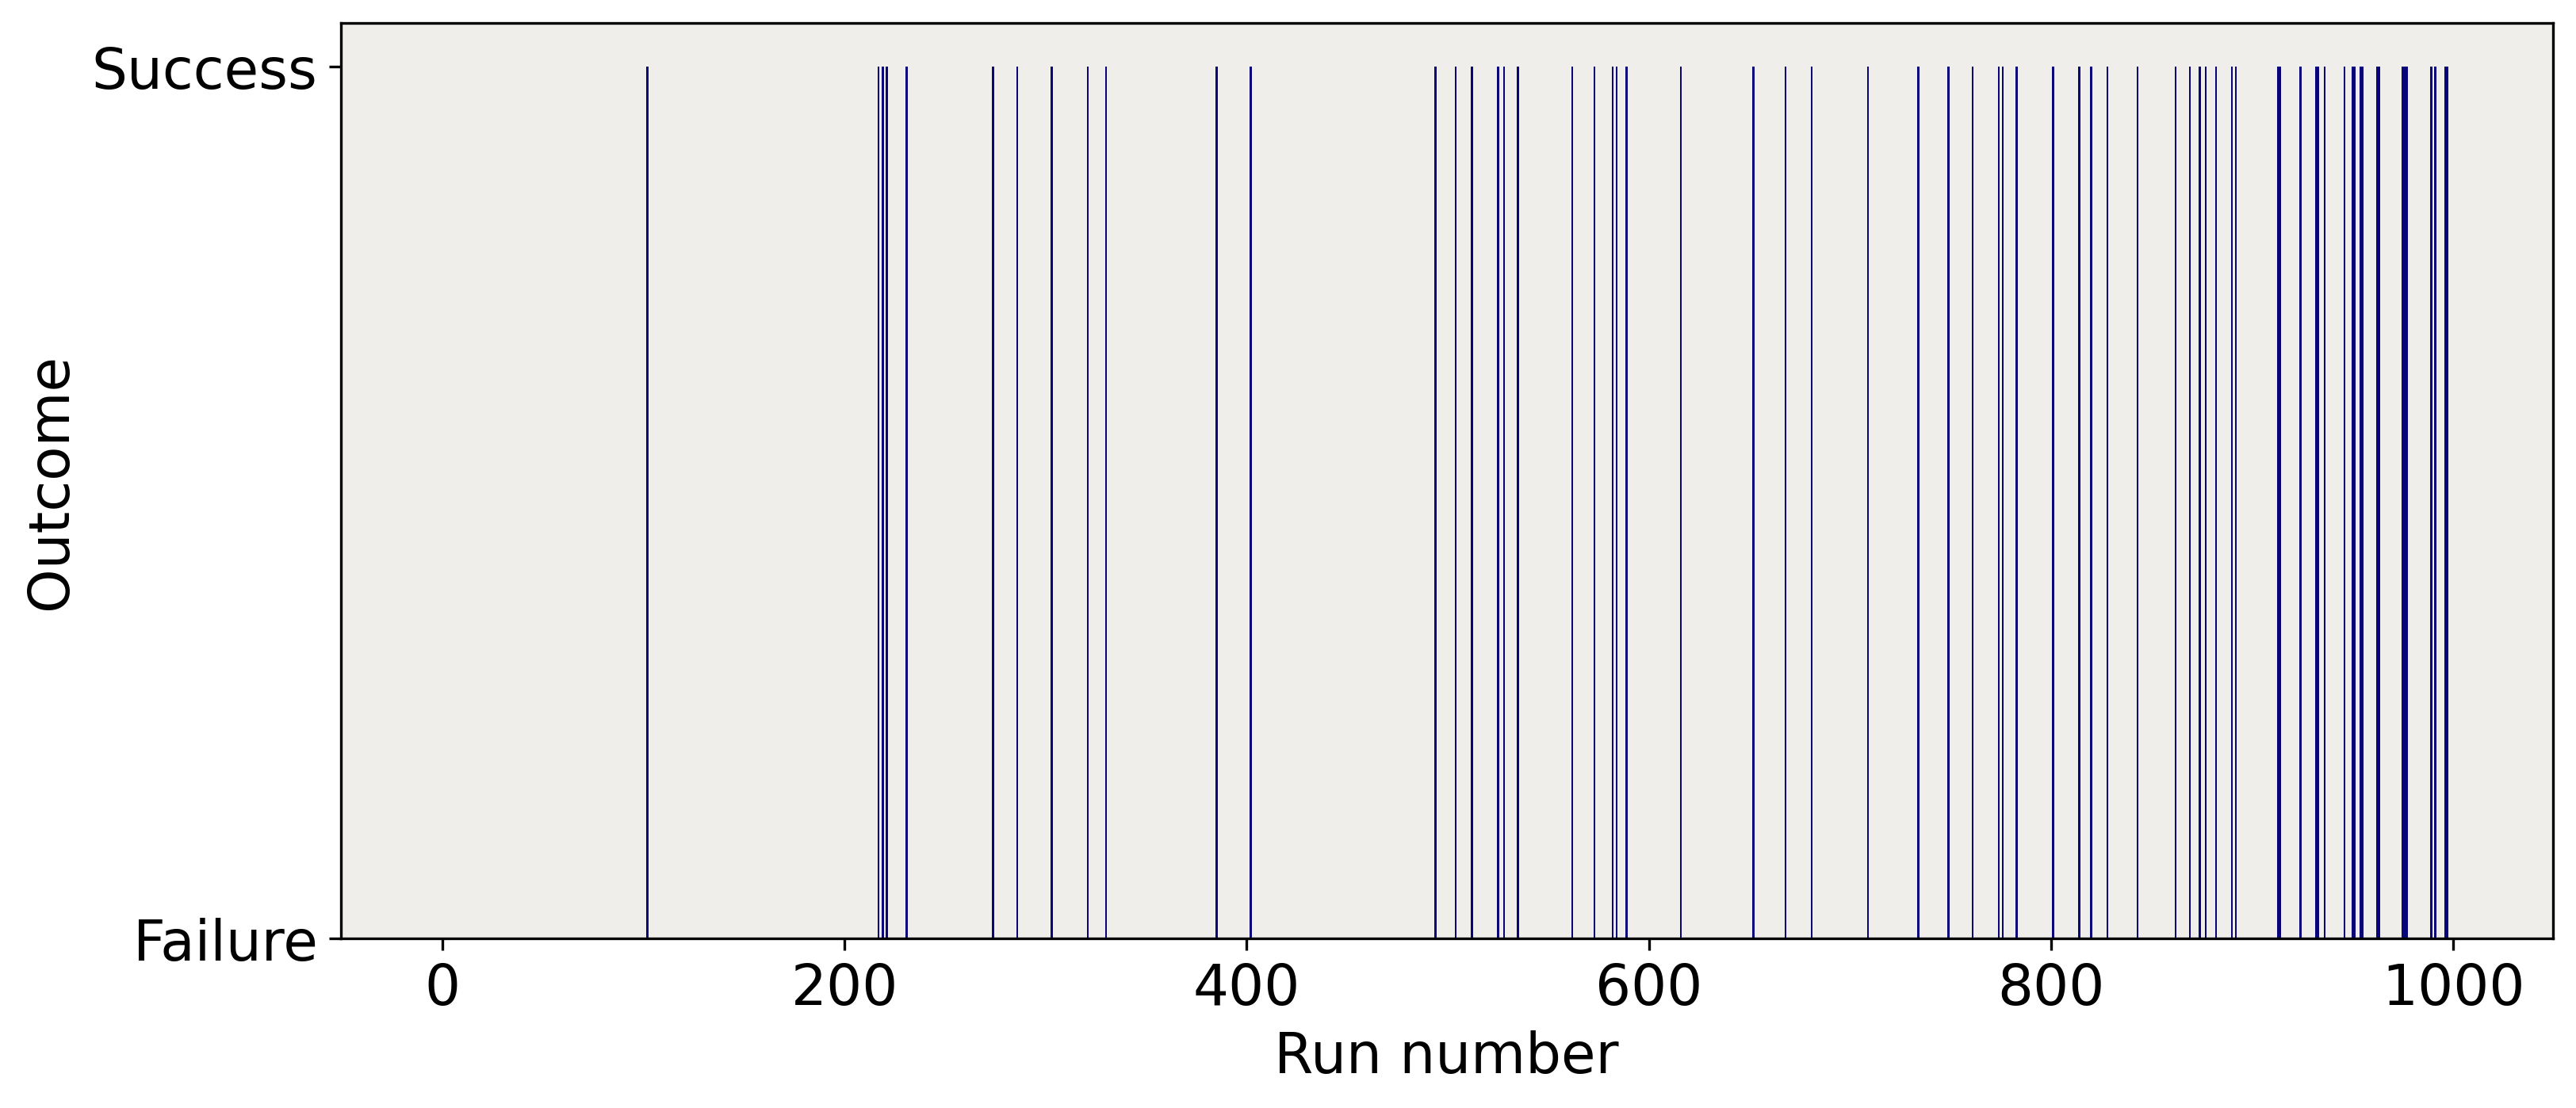

Success rate = 28.999999999999996%


In [29]:
environment = gym.make("FrozenLake-v1", is_slippery=True)
environment.reset()

# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

# List of outcomes to plot
outcomes = []

print('Q-table before training:')
print(qtable)

# Training
for _ in range(episodes):
    state = environment.reset()[0]
    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # Generate a random number between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:
            action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:
            action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()

episodes = 100
nb_success = 0

# Evaluation
for _ in range(episodes):
    state = environment.reset()[0]
    done = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, _, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print(f"Success rate = {nb_success / episodes * 100}%")


Oof it's not so good. But can you improve the performance by tweaking the different parameters we talked about?

And why not implement exponential decay for the epsilon-greedy algorithm too?

During this quick exercise, you might realise that slightly modifying the hyperparameters can completely destroy the results.

This is another quirk of reinforcement learning: hyperparameters are quite moody, and it is important to understand their meaning if you want to tweak them. It's always good to test and try new combinations to build your intuition and become more efficient. 

Good luck and have fun!